# Recurrent Neural Network Tutorial
## Written by Tim Dell
 Modified with permission from Erik Hallström.
 Medium post 'How to build RNN in tensorflow' series.
https://medium.com/@erikhallstrm/hello-world-rnn-83cd7105b767
 

This tutorial will look at how to build a simple Recurrent Neural network using the tensorflow API for RNNs. 

RNNs are a neural network used when the data is a sequence or a series of data points. This sequence does not have a fixed size.

The first step is to import the required libraries. Tensorflow, Numpy and Matplotlib for viewing.

In [46]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Next we set up the variables that we would like to be able to modify in the future. Epoch, number of iterations of learning. Series length, classes, batch size etc.


In [113]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

Next we import the data that we want to train on. In this tutorial we are going to create a series of random variables and have the recurrent network regenerate the input series a couple of time steps later

In [114]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p = [0.5,0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0
    
    
    x = x.reshape((batch_size, -1))
    y = y.reshape((batch_size, -1))
    
    return (x, y)

Following this we set up placeholders for the batches and the initial state. The placeholders are used to feed in the data to the RNN when the session begins.

In [136]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])


Next we set up the changeable variables. Using tf.Variable this initilisation allows the session to access and train on the weights and biases of the system.

In [137]:
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype = tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype = tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes), dtype = tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype = tf.float32)


The columns are unstacked to be fed into the system

In [138]:
#Unpack columns

input_series = tf.unstack(batchX_placeholder, axis = 1)
label_series = tf.unstack(batchY_placeholder, axis = 1)

The next step is to set up the forward pass.In a vanilla RNN the forward pass needs to be unrolled with a for loop and each state needs to be calculated. Later it will be shown that the tensorflow API provides a rolled out RNN inbuilt in the library. It is seen that the system is reshaped to be fed into a tanh activation function.

In [139]:
#Forward Pass

current_state = init_state
states_series = []

for current_input in input_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concat = tf.concat( [current_input, current_state], 1)
    
    next_state = tf.tanh(tf.matmul(input_and_state_concat, W) + b)
    states_series.append(next_state)
    current_state = next_state
    

Then we set up the logits and predictions of the series and apply a softmax layer to the results.
The system then initialises the error function using reduce_mean and the gradient descent algorithm, seen here with the inbuilt adagrad optimiser.

In [140]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = labels) for logits, labels in zip(logits_series,label_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

We then build a function to plot the results of the training. 

In [141]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)
    
    
    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])
        
        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width = 1, color = "blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width = 1, color = "red" )
        plt.bar(left_offset, single_output_series * 0.3, width = 1, color = "green")
        
    plt.draw()
    plt.pause(0.0001)
    


Finally we initialise the actual training with the with tf.Session() line. The system then runs through the epochs  and generates the input data, nest it runs the training across the data and produces the loss and the predictions. The system then outputs on the display an indicator wshowing the step and the loss at an interval of every 100 batches.

New Data, epoch 0
Step 0 Loss 0.701099
Step 100 Loss 0.693073
Step 200 Loss 0.689492
Step 300 Loss 0.693039
Step 400 Loss 0.697603
Step 500 Loss 0.701983
Step 600 Loss 0.692726
New Data, epoch 1
Step 0 Loss 0.693576
Step 100 Loss 0.691514
Step 200 Loss 0.712362
Step 300 Loss 0.687532
Step 400 Loss 0.694719
Step 500 Loss 0.693438
Step 600 Loss 0.691848
New Data, epoch 2
Step 0 Loss 0.695305
Step 100 Loss 0.694315
Step 200 Loss 0.699786
Step 300 Loss 0.708219
Step 400 Loss 0.690003
Step 500 Loss 0.692914
Step 600 Loss 0.69462
New Data, epoch 3
Step 0 Loss 0.709068
Step 100 Loss 0.693923
Step 200 Loss 0.693917
Step 300 Loss 0.694533
Step 400 Loss 0.693444
Step 500 Loss 0.692315
Step 600 Loss 0.695702
New Data, epoch 4
Step 0 Loss 0.702585
Step 100 Loss 0.692496
Step 200 Loss 0.692783
Step 300 Loss 0.693353
Step 400 Loss 0.701668
Step 500 Loss 0.698014
Step 600 Loss 0.693031
New Data, epoch 5
Step 0 Loss 0.692995
Step 100 Loss 0.69309
Step 200 Loss 0.692706
Step 300 Loss 0.689929
Step 400 

Step 200 Loss 0.693014
Step 300 Loss 0.694316
Step 400 Loss 0.694904
Step 500 Loss 0.699457
Step 600 Loss 0.694532
New Data, epoch 47
Step 0 Loss 0.694398
Step 100 Loss 0.693079
Step 200 Loss 0.693809
Step 300 Loss 0.692751
Step 400 Loss 0.699662
Step 500 Loss 0.689977
Step 600 Loss 0.694662
New Data, epoch 48
Step 0 Loss 0.694952
Step 100 Loss 0.700122
Step 200 Loss 0.693139
Step 300 Loss 0.691965
Step 400 Loss 0.692501
Step 500 Loss 0.696215
Step 600 Loss 0.697282
New Data, epoch 49
Step 0 Loss 0.691778
Step 100 Loss 0.693837
Step 200 Loss 0.703508
Step 300 Loss 0.693049
Step 400 Loss 0.693079
Step 500 Loss 0.690323
Step 600 Loss 0.693523
New Data, epoch 50
Step 0 Loss 0.69334
Step 100 Loss 0.696094
Step 200 Loss 0.692605
Step 300 Loss 0.689397
Step 400 Loss 0.689335
Step 500 Loss 0.694494
Step 600 Loss 0.693343
New Data, epoch 51
Step 0 Loss 0.691517
Step 100 Loss 0.697145
Step 200 Loss 0.692491
Step 300 Loss 0.692539
Step 400 Loss 0.693365
Step 500 Loss 0.693487
Step 600 Loss 0.692

Step 400 Loss 0.691426
Step 500 Loss 0.692098
Step 600 Loss 0.691272
New Data, epoch 93
Step 0 Loss 0.685584
Step 100 Loss 0.694189
Step 200 Loss 0.688721
Step 300 Loss 0.691734
Step 400 Loss 0.688839
Step 500 Loss 0.694007
Step 600 Loss 0.689071
New Data, epoch 94
Step 0 Loss 0.691329
Step 100 Loss 0.698077
Step 200 Loss 0.693128
Step 300 Loss 0.692531
Step 400 Loss 0.693421
Step 500 Loss 0.693174
Step 600 Loss 0.693033
New Data, epoch 95
Step 0 Loss 0.6902
Step 100 Loss 0.697924
Step 200 Loss 0.69257
Step 300 Loss 0.689247
Step 400 Loss 0.690422
Step 500 Loss 0.691907
Step 600 Loss 0.693213
New Data, epoch 96
Step 0 Loss 0.688144
Step 100 Loss 0.69338
Step 200 Loss 0.692804
Step 300 Loss 0.692753
Step 400 Loss 0.691547
Step 500 Loss 0.692641
Step 600 Loss 0.693708
New Data, epoch 97
Step 0 Loss 0.68136
Step 100 Loss 0.694522
Step 200 Loss 0.691783
Step 300 Loss 0.692247
Step 400 Loss 0.693607
Step 500 Loss 0.692022
Step 600 Loss 0.690129
New Data, epoch 98
Step 0 Loss 0.683555
Step 1

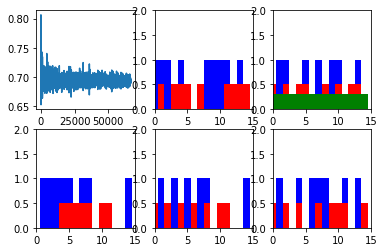

In [76]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []
    
    for epoch_idx in range(num_epochs):
        x, y = generateData()
        _current_state = np.zeros((batch_size, state_size))
        print("New Data, epoch", epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:,start_idx: end_idx]
            batchY = y[:,start_idx: end_idx]
            
            _total_loss, _train_loss, _current_state, _predictions_series = sess.run(
            [total_loss,train_step,current_state,predictions_series],
            feed_dict = { batchX_placeholder:batchX,
                        batchY_placeholder:batchY,
                        init_state:_current_state})
            loss_list.append(_total_loss)
            
            if batch_idx%100 == 0:
                print("Step", batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)
                

plt.show()

This program produces a series of plots that show the input data being learnt and repeated x samples after the input is provided.

## RNN API


Going back to the forward pass, we can make use of tensorflows APIs, we first begin by modifying the tanh function and then appending and reshaping code and just write tf.contrib.rnn.BasicRNNCell(state_size) and add tf.contrib.rnn(cell, inputs, init_state

Replacing the long for loop iterating through the length of the input. The tf.nn.rnn unrolls the RNN and creates the graph automatically, so the loop can be removed

In [142]:
#Forward Pass

#Modify Unpack columns
#inputs_series = tf.unstack(batchX_placeholder, axis=1)
#labels_series = tf.unstack(batchY_placeholder, axis=1)

# Replace

# Forward pass
#current_state = init_state
#states_series = []
#for current_input in inputs_series:
#    current_input = tf.reshape(current_input, [batch_size, 1])
#    input_and_state_concatenated = tf.concat(1, [current_input, current_state])  # Increasing number of columns

#    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
#    states_series.append(next_state)
#    current_state = next_state




In [166]:

inputs_series = tf.split(truncated_backprop_length, batchX_placeholder , axis = 1)
labels_series = tf.unstack(batchY_placeholder, axis = 1)


# Forward passes
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, init_state)

TypeError: Value passed to parameter 'size_splits' has DataType float32 not in list of allowed values: int32, int64

The weights and biases can also be removed. Most of the RNN is woven into the Basic RNN cell structure. Split is used instead of unstack the tf.nn.dynamic_rnn accepts the input shape of [batch_size, input_size], input size is simply one. Split keeps the single dimension that we are using in this case. 

Once this is added the code is a little easier to implement. But we can improve on this using an LSTM network. The LSTM will allow us to extend our truncated_backprop_length out further without introducing the vanishing gradient problem that simple RNNs are prone to.

The LSTM has an internal cell state and a hidden state. To introduce these into the program _current_state is replaced with two lines



In [153]:
_current_cell_state = np.zeros((batch_size, state_size))
_current_hidden_state = np.zeros((batch_size, state_size))

LSTMs use LSTMStateTuple to store the data. We therefore create placeholders for cell state and hidden state and place them in the tuple,

In [154]:
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)


Now we turn BasicRNNCell into BasicLSTMCell, and then the program can calculate the results of the tuple. This is then seperated out after calculated and is supplied to the placeholders in the run function. 

In [157]:
#Result


from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)

# Unpack columns
inputs_series = tf.split( batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, init_state)

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state

                })

            _current_cell_state, _current_hidden_state = _current_state

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()


ValueError: Dimension must be 2 but is 3 for 'transpose_5' (op: 'Transpose') with input shapes: [5,1], [3].

We can further extend a simple LSTM into multilayers by changing the LSTMTuple line to a more generic _current_state line

In [95]:
_current_state = np.zeros((num_layers, 2, batch_size, state_size))

We can then modify the layer size to what ever length we like. Init state is then converted from LSTMTuple back to tf.placeholder.

In [158]:
init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])


The stateTuple is then created to encompass the multiple layers

In [159]:
state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

Finally the forward pass introduces a MultiRNNCell which links the layers together

In [160]:
# Forward passes
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, initial_state=rnn_tuple_state)


ValueError: Dimension must be 2 but is 3 for 'transpose_6' (op: 'Transpose') with input shapes: [5,1], [3].

In [27]:
#Full program

from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)


# Unpack columns

inputs_series = tf.split(truncated_backprop_length,batchX_placeholder)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True, reuse=True) for _ in range(num_layers)], state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, inputs_series, initial_state=rnn_tuple_state)

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()


ValueError: Can't split scalars for 'split_17' (op: 'SplitV') with input shapes: [], [5,15], [].

Finally to get this code to a neat fully functional LSTM we fully incorporate dynamic_rnn into the program. By doing this we don't need to split the inputs and labels into a list. Inputs_series and label_series are removed. 

In [170]:
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1), initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series, [-1, state_size])

AttributeError: 'tuple' object has no attribute 'get_shape'

In [29]:
#Full program


from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
num_layers = 3

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [num_layers, 2, batch_size, state_size])

state_per_layer_list = tf.unstack(init_state, axis=0)
rnn_tuple_state = tuple(
    [tf.contrib.rnn.LSTMStateTuple(state_per_layer_list[idx][0], state_per_layer_list[idx][1])
     for idx in range(num_layers)]
)

# Forward passes



cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True, ) for _ in range(num_layers)], state_is_tuple=True)
states_series, current_state = tf.nn.dynamic_rnn(cell, tf.expand_dims(batchX_placeholder, -1), initial_state=rnn_tuple_state)
states_series = tf.reshape(states_series, [-1, state_size])

logits = tf.matmul(states_series, W2) + b2 #Broadcasted addition
labels = tf.reshape(batchY_placeholder, [-1])

logits_series = tf.unstack(tf.reshape(logits, [batch_size, truncated_backprop_length, num_classes]), axis=1)
predictions_series = [tf.nn.softmax(logit) for logit in logits_series]


losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()

        _current_state = np.zeros((num_layers, 2, batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    init_state: _current_state
                })


            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()



ValueError: Attempt to have a second RNNCell use the weights of a variable scope that already has weights: 'rnn/multi_rnn_cell/cell_0/basic_lstm_cell'; and the cell was not constructed as BasicLSTMCell(..., reuse=True).  To share the weights of an RNNCell, simply reuse it in your second calculation, or create a new one with the argument reuse=True.